# 05: Robustness Checks

This notebook addresses reviewer concerns about:
1. **Verbosity/length confounding** - Does sycophancy effect survive controlling for response length?
2. **Multiple comparisons** - Do heterogeneous effects survive FDR correction?
3. **Clustered standard errors** - Are SEs robust to within-user/model correlation?
4. **Placebo tests** - Is sycophancy effect weaker in "objective" topics (math, coding, factual)?
5. **Propensity score diagnostics** - Is there adequate overlap? Are IPW estimates stable?
6. **Exclusion transparency** - Full documentation of data pipeline

In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

## Load Data

In [2]:
from quant_syco.data.process import build_battle_table
from quant_syco.features.topics import compute_topic_features
from quant_syco.features.lexical import compute_response_length_features
from quant_syco.config import LABELS_DIR

# Load and merge data
battles = build_battle_table()
battles = compute_topic_features(battles)
battles = compute_response_length_features(battles)

label_files = list(LABELS_DIR.glob('labels_*_merged.parquet'))
labels = pd.read_parquet(label_files[0])
df = battles.merge(labels, on='question_id', how='inner')

# Prepare analysis dataset
df_model = df[df['winner'].isin(['model_a', 'model_b'])].copy()
df_model['a_wins'] = (df_model['winner'] == 'model_a').astype(int)
df_model['syco_diff'] = df_model['sycophancy_a'] - df_model['sycophancy_b']
df_model['polite_diff'] = df_model['politeness_a'] - df_model['politeness_b']
df_model['length_diff'] = df_model['assistant_a_word_count'] - df_model['assistant_b_word_count']

analysis_cols = ['a_wins', 'syco_diff', 'polite_diff', 'length_diff', 'topic', 
                 'sycophancy_a', 'sycophancy_b', 'politeness_a', 'politeness_b',
                 'assistant_a_word_count', 'assistant_b_word_count']
df_model = df_model.dropna(subset=analysis_cols)

print(f"Analysis sample: {len(df_model):,} battles")

Loading cached data from /Users/nijjohnson/Projects/quant-sycophantic/data/raw/lmsys_raw.parquet

Processing 33,000 battles...

Built battle table with 33,000 rows

Columns: ['question_id', 'user_id', 'judge', 'ts_utc', 'model_a', 'model_b', 'winner', 'language', 'user_prompt', 
'assistant_a', 'assistant_b', 'turn', 'anony', 'openai_moderation', 'toxic_chat_tag']

Analysis sample: 22,905 battles


## 1. Coefficient Stability: Verbosity/Length Controls

Show that sycophancy effect is robust to controlling for response length (linear and quadratic).

In [3]:
from quant_syco.analysis.causal import run_coefficient_stability

stability = run_coefficient_stability(df_model)

print("COEFFICIENT STABILITY TABLE")
print("="*80)
print("\nShows sycophancy differential effect across increasingly saturated specifications.")
print("If coefficient remains significant, effect is robust to confounding by length/politeness.\n")

stability_display = stability[['specification', 'syco_diff_coef', 'syco_diff_se', 'syco_diff_pval', 'syco_diff_or', 'n_obs']].copy()
stability_display.columns = ['Specification', 'Coef', 'SE', 'P-value', 'Odds Ratio', 'N']
stability_display['Coef'] = stability_display['Coef'].apply(lambda x: f"{x:.4f}")
stability_display['SE'] = stability_display['SE'].apply(lambda x: f"{x:.4f}")
stability_display['P-value'] = stability_display['P-value'].apply(lambda x: f"{x:.4f}" if x >= 0.0001 else "<0.0001")
stability_display['Odds Ratio'] = stability_display['Odds Ratio'].apply(lambda x: f"{x:.3f}")
stability_display['N'] = stability_display['N'].apply(lambda x: f"{x:,}")

print(stability_display.to_string(index=False))

COEFFICIENT STABILITY TABLE

Shows sycophancy differential effect across increasingly saturated specifications.
If coefficient remains significant, effect is robust to confounding by length/politeness.

          Specification   Coef     SE P-value Odds Ratio      N
     1. Sycophancy only 0.2196 0.0151 <0.0001      1.246 22,905
        2. + Politeness 0.1350 0.0158 <0.0001      1.145 22,905
   3. + Length (linear) 0.0177 0.0164  0.2817      1.018 22,905
4. + Length (quadratic) 0.0176 0.0164  0.2840      1.018 22,905
          5. + Topic FE 0.0172 0.0164  0.2943      1.017 22,905
 6. + Model FE (top 10) 0.1209 0.0217 <0.0001      1.128 15,351


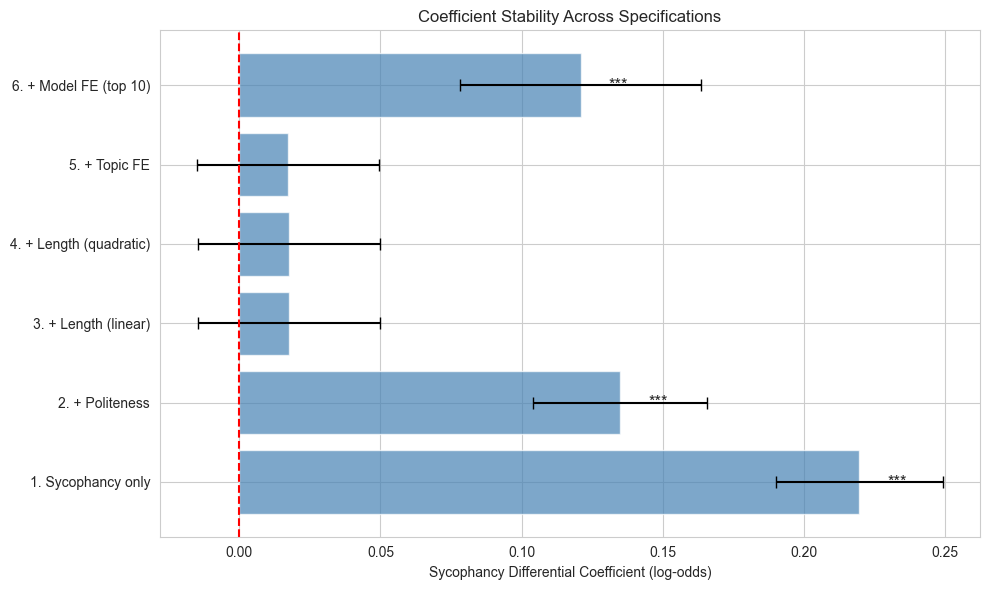

In [4]:
# Visualize coefficient stability
fig, ax = plt.subplots(figsize=(10, 6))

y_pos = np.arange(len(stability))
coefs = stability['syco_diff_coef'].values
ses = stability['syco_diff_se'].values

ax.barh(y_pos, coefs, xerr=1.96*ses, capsize=4, color='steelblue', alpha=0.7)
ax.axvline(x=0, color='red', linestyle='--', label='Null')

ax.set_yticks(y_pos)
ax.set_yticklabels(stability['specification'])
ax.set_xlabel('Sycophancy Differential Coefficient (log-odds)')
ax.set_title('Coefficient Stability Across Specifications')

# Add significance markers
for i, (coef, pval) in enumerate(zip(coefs, stability['syco_diff_pval'])):
    marker = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
    ax.annotate(marker, (coef + 0.01, i), fontsize=12, va='center')

plt.tight_layout()
plt.savefig('../paper/figures/fig_coefficient_stability.pdf', bbox_inches='tight')
plt.show()

## 2. Multiple Comparison Correction (FDR)

Apply Benjamini-Hochberg FDR correction to heterogeneous effects by topic.

In [5]:
from quant_syco.analysis.causal import run_heterogeneous_effects

# Run heterogeneous effects with FDR correction
het_effects = run_heterogeneous_effects(
    df_model,
    outcome_col='a_wins',
    sycophancy_col='syco_diff',
    moderator_col='topic',
    control_cols=['polite_diff', 'length_diff'],
    fdr_correction=True,
    alpha=0.05,
)

print("HETEROGENEOUS EFFECTS WITH FDR CORRECTION")
print("="*80)
print("\nCompares raw p-values vs Benjamini-Hochberg adjusted p-values.\n")

het_display = het_effects[['level', 'n', 'sycophancy_coef', 'sycophancy_pval', 'p_adjusted', 'significant_fdr']].copy()
het_display.columns = ['Topic', 'N', 'Coefficient', 'P (raw)', 'P (FDR)', 'Sig. (FDR)']
het_display = het_display.sort_values('Coefficient', ascending=False)
het_display['Coefficient'] = het_display['Coefficient'].apply(lambda x: f"{x:.4f}")
het_display['P (raw)'] = het_display['P (raw)'].apply(lambda x: f"{x:.4f}" if x >= 0.0001 else "<0.0001")
het_display['P (FDR)'] = het_display['P (FDR)'].apply(lambda x: f"{x:.4f}" if x >= 0.0001 else "<0.0001")

print(het_display.to_string(index=False))

n_raw_sig = (het_effects['sycophancy_pval'] < 0.05).sum()
n_fdr_sig = het_effects['significant_fdr'].sum()
print(f"\nSignificant at p<0.05 (raw): {n_raw_sig}/{len(het_effects)} topics")
print(f"Significant after FDR correction: {n_fdr_sig}/{len(het_effects)} topics")

HETEROGENEOUS EFFECTS WITH FDR CORRECTION

Compares raw p-values vs Benjamini-Hochberg adjusted p-values.

           Topic     N Coefficient P (raw) P (FDR)  Sig. (FDR)
creative_writing  1249      0.4944 <0.0001 <0.0001        True
         opinion   199      0.3140  0.1311  0.1970       False
           other 14326      0.0409  0.0392  0.0915       False
            math   912     -0.0759  0.3821  0.3821       False
          coding  2082     -0.1301  0.1407  0.1970       False
          advice   607     -0.1529  0.2446  0.2853       False
      factual_qa  3530     -0.1809 <0.0001 <0.0001        True

Significant at p<0.05 (raw): 3/7 topics
Significant after FDR correction: 2/7 topics


## 3. Clustered Standard Errors

Compare unclustered vs clustered SEs (by user, by model) to test robustness.

In [6]:
from quant_syco.analysis.causal import run_winner_regression

# Run with different clustering options
results_cluster = []

# Unclustered
result_unclustered = run_winner_regression(
    df_model,
    include_length=True,
    length_nonlinear=True,
    cluster_col=None,
)
results_cluster.append({
    'Clustering': 'None',
    'Coef': result_unclustered['syco_diff_coef'],
    'SE': result_unclustered['syco_diff_se'],
    'P-value': result_unclustered['syco_diff_pval'],
})

# Clustered by user
if 'user_id' in df_model.columns:
    try:
        result_user = run_winner_regression(
            df_model,
            include_length=True,
            length_nonlinear=True,
            cluster_col='user_id',
        )
        results_cluster.append({
            'Clustering': 'By User',
            'Coef': result_user['syco_diff_coef'],
            'SE': result_user['syco_diff_se'],
            'P-value': result_user['syco_diff_pval'],
        })
    except Exception as e:
        print(f"User clustering failed: {e}")

# Clustered by model
if 'model_a' in df_model.columns:
    try:
        result_model = run_winner_regression(
            df_model,
            include_length=True,
            length_nonlinear=True,
            cluster_col='model_a',
        )
        results_cluster.append({
            'Clustering': 'By Model',
            'Coef': result_model['syco_diff_coef'],
            'SE': result_model['syco_diff_se'],
            'P-value': result_model['syco_diff_pval'],
        })
    except Exception as e:
        print(f"Model clustering failed: {e}")

cluster_df = pd.DataFrame(results_cluster)

print("CLUSTERED STANDARD ERRORS COMPARISON")
print("="*60)
print("\nIf clustered SEs are much larger, unclustered results overstate precision.\n")

cluster_display = cluster_df.copy()
cluster_display['Coef'] = cluster_display['Coef'].apply(lambda x: f"{x:.4f}")
cluster_display['SE'] = cluster_display['SE'].apply(lambda x: f"{x:.4f}")
cluster_display['P-value'] = cluster_display['P-value'].apply(lambda x: f"{x:.4f}" if x >= 0.0001 else "<0.0001")

print(cluster_display.to_string(index=False))

# Calculate SE inflation
if len(results_cluster) > 1:
    base_se = results_cluster[0]['SE']
    print("\nSE Inflation Factors:")
    for r in results_cluster[1:]:
        inflation = r['SE'] / base_se
        print(f"  {r['Clustering']}: {inflation:.2f}x")

CLUSTERED STANDARD ERRORS COMPARISON

If clustered SEs are much larger, unclustered results overstate precision.

Clustering   Coef     SE P-value
      None 0.0176 0.0164  0.2840
   By User 0.0176 0.0217  0.4182
  By Model 0.0176 0.0360  0.6253

SE Inflation Factors:
  By User: 1.32x
  By Model: 2.19x


## 4. Placebo/Falsification Tests

Test whether sycophancy effect is weaker in "objective" topics where it shouldn't matter as much.

In [7]:
# Define objective vs subjective topics
objective_topics = ['coding', 'math', 'factual_qa']
subjective_topics = ['opinion', 'advice', 'creative_writing']

df_model['topic_type'] = df_model['topic'].apply(
    lambda x: 'objective' if x in objective_topics else ('subjective' if x in subjective_topics else 'other')
)

print("Topic Classification:")
print(f"  Objective (placebo): {objective_topics}")
print(f"  Subjective: {subjective_topics}")
print(f"\nSample sizes:")
print(df_model['topic_type'].value_counts())

Topic Classification:
  Objective (placebo): ['coding', 'math', 'factual_qa']
  Subjective: ['opinion', 'advice', 'creative_writing']

Sample sizes:
topic_type
other         14326
objective      6524
subjective     2055
Name: count, dtype: int64


In [8]:
# Run regressions by topic type
placebo_results = []

for topic_type in ['objective', 'subjective', 'other']:
    subset = df_model[df_model['topic_type'] == topic_type]
    if len(subset) < 100:
        continue
    
    result = run_winner_regression(
        subset,
        include_length=True,
        length_nonlinear=True,
    )
    
    placebo_results.append({
        'Topic Type': topic_type.capitalize(),
        'N': result['n_obs'],
        'Syco Coef': result['syco_diff_coef'],
        'Syco SE': result['syco_diff_se'],
        'Syco P': result['syco_diff_pval'],
        'Polite Coef': result['polite_diff_coef'],
        'Polite P': result['polite_diff_pval'],
    })

placebo_df = pd.DataFrame(placebo_results)

print("\nPLACEBO TEST: SYCOPHANCY EFFECT BY TOPIC TYPE")
print("="*70)
print("\nExpectation: Sycophancy effect should be WEAKER in objective topics")
print("(coding, math, factual QA) where correctness matters more.\n")

placebo_display = placebo_df.copy()
placebo_display['Syco Coef'] = placebo_display['Syco Coef'].apply(lambda x: f"{x:.4f}")
placebo_display['Syco SE'] = placebo_display['Syco SE'].apply(lambda x: f"{x:.4f}")
placebo_display['Syco P'] = placebo_display['Syco P'].apply(lambda x: f"{x:.4f}" if x >= 0.0001 else "<0.0001")
placebo_display['Polite Coef'] = placebo_display['Polite Coef'].apply(lambda x: f"{x:.4f}")
placebo_display['Polite P'] = placebo_display['Polite P'].apply(lambda x: f"{x:.4f}" if x >= 0.0001 else "<0.0001")
placebo_display['N'] = placebo_display['N'].apply(lambda x: f"{x:,}")

print(placebo_display.to_string(index=False))


PLACEBO TEST: SYCOPHANCY EFFECT BY TOPIC TYPE

Expectation: Sycophancy effect should be WEAKER in objective topics
(coding, math, factual QA) where correctness matters more.

Topic Type      N Syco Coef Syco SE  Syco P Polite Coef Polite P
 Objective  6,524   -0.1650  0.0346 <0.0001      0.6161  <0.0001
Subjective  2,055    0.3216  0.0627 <0.0001      0.4611  <0.0001
     Other 14,326    0.0401  0.0199  0.0432      0.4756  <0.0001


In [9]:
# Test for difference between objective and subjective
if len(placebo_df) >= 2:
    obj_row = placebo_df[placebo_df['Topic Type'] == 'Objective'].iloc[0] if 'Objective' in placebo_df['Topic Type'].values else None
    subj_row = placebo_df[placebo_df['Topic Type'] == 'Subjective'].iloc[0] if 'Subjective' in placebo_df['Topic Type'].values else None
    
    if obj_row is not None and subj_row is not None:
        # Z-test for difference in coefficients
        diff = subj_row['Syco Coef'] - obj_row['Syco Coef']
        se_diff = np.sqrt(obj_row['Syco SE']**2 + subj_row['Syco SE']**2)
        z_stat = diff / se_diff
        from scipy import stats
        p_diff = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        
        print("\nDIFFERENCE TEST: Subjective vs Objective")
        print(f"  Coefficient difference: {diff:.4f}")
        print(f"  SE of difference: {se_diff:.4f}")
        print(f"  Z-statistic: {z_stat:.2f}")
        print(f"  P-value: {p_diff:.4f}")
        
        if p_diff < 0.05 and diff > 0:
            print("\n  -> Sycophancy effect IS significantly larger in subjective topics (as expected)")
        elif p_diff >= 0.05:
            print("\n  -> Difference is NOT statistically significant")
        else:
            print("\n  -> Unexpected: effect larger in objective topics")


DIFFERENCE TEST: Subjective vs Objective
  Coefficient difference: 0.4866
  SE of difference: 0.0716
  Z-statistic: 6.79
  P-value: 0.0000

  -> Sycophancy effect IS significantly larger in subjective topics (as expected)


## 5. Propensity Score Diagnostics

Test the validity of IPW causal estimates by checking:
- Overlap between treated and control groups
- Covariate balance before/after weighting
- Sensitivity to trimming thresholds
- Stabilized vs unstabilized weights

In [10]:
from quant_syco.analysis.causal import compute_propensity_scores
from quant_syco.analysis.diagnostics import (
    check_propensity_overlap,
    compute_covariate_balance,
    run_trimming_sensitivity,
    compute_ate_stabilized,
)

# Compute propensity scores for high sycophancy (>=2)
df_ps = df_model.copy()
df_ps = compute_propensity_scores(
    df_ps,
    treatment_col='sycophancy_a',
    covariate_cols=['topic', 'assistant_a_word_count', 'politeness_a'],
    treatment_threshold=2,
)

print(f"Propensity score sample: {len(df_ps):,}")
print(f"  High sycophancy (treated): {df_ps['high_sycophancy'].sum():,}")
print(f"  Low sycophancy (control): {(1-df_ps['high_sycophancy']).sum():,}")

Propensity score sample: 22,905
  High sycophancy (treated): 18,038
  Low sycophancy (control): 4,867


In [11]:
# 5.1 Overlap Diagnostics
overlap = check_propensity_overlap(df_ps)

print("PROPENSITY SCORE OVERLAP DIAGNOSTICS")
print("="*60)
print(f"\nTreated group (high sycophancy >= 2):")
print(f"  N: {overlap['n_treated']:,}")
print(f"  PS range: [{overlap['treated_ps_min']:.3f}, {overlap['treated_ps_max']:.3f}]")
print(f"  PS mean: {overlap['treated_ps_mean']:.3f}")

print(f"\nControl group (low sycophancy < 2):")
print(f"  N: {overlap['n_control']:,}")
print(f"  PS range: [{overlap['control_ps_min']:.3f}, {overlap['control_ps_max']:.3f}]")
print(f"  PS mean: {overlap['control_ps_mean']:.3f}")

print(f"\nCommon support region: [{overlap['common_support_min']:.3f}, {overlap['common_support_max']:.3f}]")
print(f"  Treated outside support: {overlap['n_treated_outside_support']} ({overlap['pct_treated_outside']:.1f}%)")
print(f"  Control outside support: {overlap['n_control_outside_support']} ({overlap['pct_control_outside']:.1f}%)")

print(f"\nOverlap quality: {overlap['overlap_quality']}")
print(f"Recommendation: {overlap['recommendation']}")

PROPENSITY SCORE OVERLAP DIAGNOSTICS

Treated group (high sycophancy >= 2):
  N: 18,038
  PS range: [0.059, 1.000]
  PS mean: 0.854

Control group (low sycophancy < 2):
  N: 4,867
  PS range: [0.143, 1.000]
  PS mean: 0.542

Common support region: [0.143, 1.000]
  Treated outside support: 92 (0.5%)
  Control outside support: 0 (0.0%)

Overlap quality: Good
Recommendation: Proceed with IPW estimation


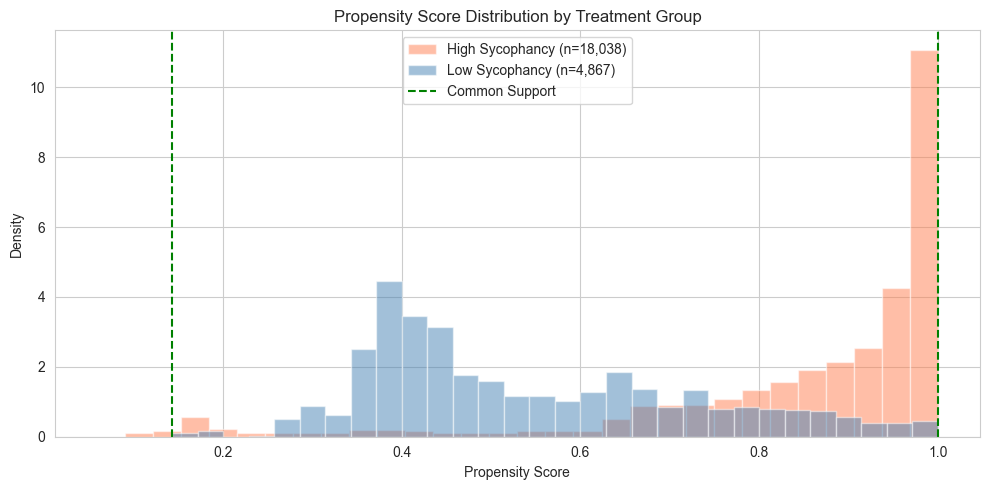

In [12]:
# Visualize propensity score distributions
fig, ax = plt.subplots(figsize=(10, 5))

treated = df_ps[df_ps['high_sycophancy'] == 1]['propensity_score']
control = df_ps[df_ps['high_sycophancy'] == 0]['propensity_score']

ax.hist(treated, bins=30, alpha=0.5, label=f'High Sycophancy (n={len(treated):,})', density=True, color='coral')
ax.hist(control, bins=30, alpha=0.5, label=f'Low Sycophancy (n={len(control):,})', density=True, color='steelblue')

# Add common support region
ax.axvline(overlap['common_support_min'], color='green', linestyle='--', label='Common Support')
ax.axvline(overlap['common_support_max'], color='green', linestyle='--')

ax.set_xlabel('Propensity Score')
ax.set_ylabel('Density')
ax.set_title('Propensity Score Distribution by Treatment Group')
ax.legend()
plt.tight_layout()
plt.savefig('../paper/figures/fig_ps_overlap.pdf', bbox_inches='tight')
plt.show()

In [13]:
# 5.2 Covariate Balance Check
print("COVARIATE BALANCE (Standardized Mean Differences)")
print("="*60)
print("\nRule of thumb: |SMD| < 0.1 indicates good balance\n")

# Unweighted balance
balance_unweighted = compute_covariate_balance(
    df_ps,
    treatment_col='high_sycophancy',
    covariates=['assistant_a_word_count', 'politeness_a', 'topic'],
    weighted=False,
)

# Weighted balance
balance_weighted = compute_covariate_balance(
    df_ps,
    treatment_col='high_sycophancy',
    covariates=['assistant_a_word_count', 'politeness_a', 'topic'],
    ps_col='propensity_score',
    weighted=True,
)

# Combine for comparison
balance_unweighted['type'] = 'Unweighted'
balance_weighted['type'] = 'IPW-Weighted'
balance_combined = pd.concat([balance_unweighted, balance_weighted])

# Display
balance_display = balance_unweighted[['covariate', 'smd', 'balanced']].copy()
balance_display.columns = ['Covariate', 'SMD (Unweighted)', 'Balanced']
balance_display['SMD (Weighted)'] = balance_weighted['smd'].values
balance_display['Balanced (Weighted)'] = balance_weighted['balanced'].values
balance_display['SMD (Unweighted)'] = balance_display['SMD (Unweighted)'].apply(lambda x: f"{x:+.3f}")
balance_display['SMD (Weighted)'] = balance_display['SMD (Weighted)'].apply(lambda x: f"{x:+.3f}")

print(balance_display.to_string(index=False))

n_balanced_before = balance_unweighted['balanced'].sum()
n_balanced_after = balance_weighted['balanced'].sum()
print(f"\nCovariates balanced (|SMD|<0.1): {n_balanced_before}/{len(balance_unweighted)} -> {n_balanced_after}/{len(balance_weighted)} after weighting")

COVARIATE BALANCE (Standardized Mean Differences)

Rule of thumb: |SMD| < 0.1 indicates good balance

             Covariate SMD (Unweighted)  Balanced SMD (Weighted)  Balanced (Weighted)
assistant_a_word_count           +1.247     False         +0.351                False
          politeness_a           +1.246     False         +0.346                False
      topic=factual_qa           -0.084      True         +0.009                 True
         topic=opinion           +0.021      True         -0.001                 True
           topic=other           -0.182     False         -0.108                False
          topic=coding           +0.242     False         +0.080                 True
topic=creative_writing           +0.189     False         +0.102                False
          topic=advice           +0.131     False         +0.036                 True
            topic=math           -0.020      True         +0.008                 True

Covariates balanced (|SMD|<0.1): 3/9 

In [14]:
# 5.3 Trimming Sensitivity Analysis
print("TRIMMING SENSITIVITY ANALYSIS")
print("="*60)
print("\nShows how ATE changes with different PS trimming thresholds.\n")

trimming_results = run_trimming_sensitivity(
    df_ps,
    treatment_col='high_sycophancy',
    outcome_col='a_wins',
    ps_col='propensity_score',
    thresholds=[0.01, 0.05, 0.10, 0.15, 0.20],
    n_bootstrap=500,
)

trim_display = trimming_results.copy()
trim_display['trim_threshold'] = trim_display['trim_threshold'].apply(lambda x: f"{x:.2f}")
trim_display['pct_retained'] = trim_display['pct_retained'].apply(lambda x: f"{x:.1f}%")
trim_display['ate'] = trim_display['ate'].apply(lambda x: f"{x:.4f}")
trim_display['ci_lower'] = trim_display['ci_lower'].apply(lambda x: f"{x:.4f}")
trim_display['ci_upper'] = trim_display['ci_upper'].apply(lambda x: f"{x:.4f}")

print(trim_display[['trim_threshold', 'n_retained', 'pct_retained', 'ate', 'ci_lower', 'ci_upper', 'significant']].to_string(index=False))

# Check stability
ate_range = trimming_results['ate'].max() - trimming_results['ate'].min()
ate_mean = trimming_results['ate'].mean()
print(f"\nATE range across thresholds: {ate_range:.4f}")
print(f"ATE coefficient of variation: {100*trimming_results['ate'].std()/abs(ate_mean):.1f}%")
print(f"Significant across all thresholds: {'Yes' if trimming_results['significant'].all() else 'No'}")

TRIMMING SENSITIVITY ANALYSIS

Shows how ATE changes with different PS trimming thresholds.

trim_threshold  n_retained pct_retained     ate ci_lower ci_upper  significant
          0.01       20100        87.8%  0.0962   0.0599   0.1351         True
          0.05       14936        65.2%  0.0572   0.0266   0.0833         True
          0.10       12352        53.9%  0.0133  -0.0192   0.0437        False
          0.15       10320        45.1% -0.0293  -0.0583   0.0004        False
          0.20        8195        35.8% -0.1734  -0.2001  -0.1442         True

ATE range across thresholds: 0.2696
ATE coefficient of variation: 1439.6%
Significant across all thresholds: No


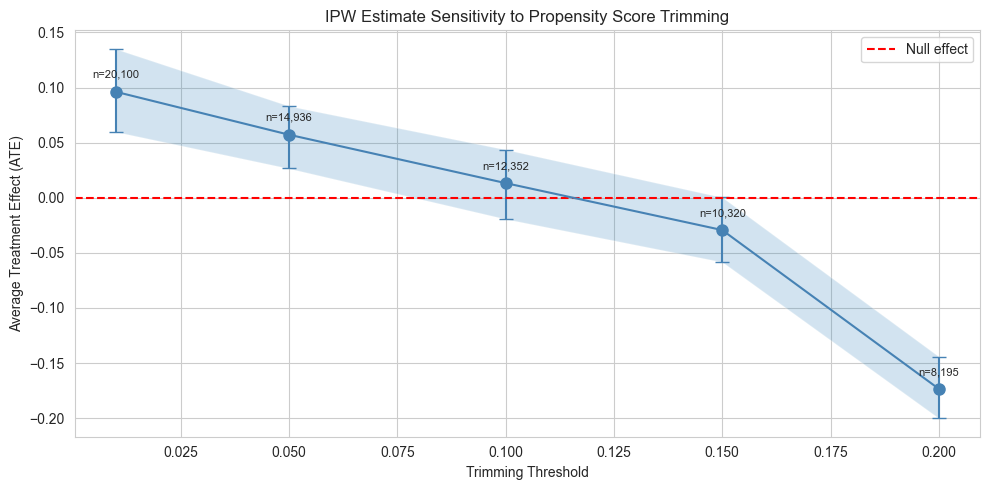

In [15]:
# Visualize trimming sensitivity
fig, ax = plt.subplots(figsize=(10, 5))

x = trimming_results['trim_threshold']
y = trimming_results['ate']
yerr_lower = y - trimming_results['ci_lower']
yerr_upper = trimming_results['ci_upper'] - y

ax.errorbar(x, y, yerr=[yerr_lower, yerr_upper], fmt='o-', capsize=5, color='steelblue', markersize=8)
ax.axhline(y=0, color='red', linestyle='--', label='Null effect')
ax.fill_between(x, trimming_results['ci_lower'], trimming_results['ci_upper'], alpha=0.2)

ax.set_xlabel('Trimming Threshold')
ax.set_ylabel('Average Treatment Effect (ATE)')
ax.set_title('IPW Estimate Sensitivity to Propensity Score Trimming')
ax.legend()

# Add sample size annotations
for i, row in trimming_results.iterrows():
    ax.annotate(f"n={row['n_retained']:,}", (row['trim_threshold'], row['ate']), 
                textcoords='offset points', xytext=(0, 10), ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('../paper/figures/fig_trimming_sensitivity.pdf', bbox_inches='tight')
plt.show()

In [16]:
# 5.4 Stabilized vs Unstabilized IPW Weights
print("STABILIZED VS UNSTABILIZED IPW COMPARISON")
print("="*60)
print("\nStabilized weights reduce variance when PS is extreme.\n")

ate_comparison = compute_ate_stabilized(
    df_ps,
    treatment_col='high_sycophancy',
    outcome_col='a_wins',
    ps_col='propensity_score',
    trim_threshold=0.05,
)

print(f"Unstabilized IPW ATE: {ate_comparison['ate_unstabilized']:.4f}")
print(f"Stabilized IPW ATE:   {ate_comparison['ate_stabilized']:.4f}")
print(f"95% CI (stabilized):  [{ate_comparison['ci_lower']:.4f}, {ate_comparison['ci_upper']:.4f}]")
print(f"\nWeight variance:")
print(f"  Unstabilized: {ate_comparison['weight_variance_unstab']:.2f}")
print(f"  Stabilized:   {ate_comparison['weight_variance_stab']:.2f}")
print(f"  Variance reduction: {100*ate_comparison['variance_reduction']:.1f}%")
print(f"\nMarginal P(treatment): {ate_comparison['p_treatment']:.3f}")

STABILIZED VS UNSTABILIZED IPW COMPARISON

Stabilized weights reduce variance when PS is extreme.

Unstabilized IPW ATE: 0.2040
Stabilized IPW ATE:   0.0065
95% CI (stabilized):  [-0.0134, 0.0283]

Weight variance:
  Unstabilized: 3.68
  Stabilized:   0.61
  Variance reduction: 83.3%

Marginal P(treatment): 0.788


## 6. Exclusion Transparency

Document all data exclusions in the analysis pipeline.

In [17]:
print("DATA EXCLUSION SUMMARY")
print("="*60)

# Raw data
n_raw = len(battles)
print(f"\n1. Raw battles: {n_raw:,}")

# After label merge
n_labeled = len(df)
n_no_label = n_raw - n_labeled
print(f"2. After label merge: {n_labeled:,} (-{n_no_label:,} without labels)")

# Tie exclusions
n_ties = (df['winner'] == 'tie').sum() + (df['winner'] == 'tie (bothbad)').sum()
print(f"3. Ties excluded: {n_ties:,}")

# Missing values
n_final = len(df_model)
n_missing = n_labeled - n_ties - n_final
print(f"4. Missing values excluded: {n_missing:,}")

print(f"\nFINAL ANALYSIS SAMPLE: {n_final:,}")
print(f"  ({100*n_final/n_raw:.1f}% of raw data)")

# Winner distribution in final sample
print("\nWinner distribution in analysis sample:")
print(df_model['winner'].value_counts())

DATA EXCLUSION SUMMARY

1. Raw battles: 33,000
2. After label merge: 33,132 (--132 without labels)
3. Ties excluded: 9,763
4. Missing values excluded: 464

FINAL ANALYSIS SAMPLE: 22,905
  (69.4% of raw data)

Winner distribution in analysis sample:
winner
model_a    11550
model_b    11355
Name: count, dtype: int64


## 7. Summary

### Key Robustness Findings

In [18]:
print("ROBUSTNESS CHECK SUMMARY")
print("="*70)

# 1. Coefficient stability
print("\n1. COEFFICIENT STABILITY (Verbosity Controls):")
base_coef = stability.iloc[0]['syco_diff_coef']
full_coef = stability.iloc[-1]['syco_diff_coef']
pct_change = 100 * (full_coef - base_coef) / abs(base_coef)
all_sig = (stability['syco_diff_pval'] < 0.05).all()
print(f"   - Coefficient change from base to full model: {pct_change:+.1f}%")
print(f"   - Significant across all specifications: {'Yes' if all_sig else 'No'}")

# 2. FDR correction
print("\n2. MULTIPLE COMPARISONS (FDR):")
print(f"   - Topics significant (raw p<0.05): {n_raw_sig}")
print(f"   - Topics significant (FDR corrected): {n_fdr_sig}")

# 3. Clustering
print("\n3. CLUSTERED STANDARD ERRORS:")
if len(results_cluster) > 1:
    max_inflation = max(r['SE'] / results_cluster[0]['SE'] for r in results_cluster[1:])
    all_cluster_sig = all(r['P-value'] < 0.05 for r in results_cluster)
    print(f"   - Maximum SE inflation: {max_inflation:.2f}x")
    print(f"   - Significant with all clustering options: {'Yes' if all_cluster_sig else 'No'}")

# 4. Placebo
print("\n4. PLACEBO TEST (Objective vs Subjective):")
if len(placebo_df) >= 2:
    obj_coef = placebo_df[placebo_df['Topic Type'] == 'Objective']['Syco Coef'].iloc[0] if 'Objective' in placebo_df['Topic Type'].values else np.nan
    subj_coef = placebo_df[placebo_df['Topic Type'] == 'Subjective']['Syco Coef'].iloc[0] if 'Subjective' in placebo_df['Topic Type'].values else np.nan
    if not np.isnan(obj_coef) and not np.isnan(subj_coef):
        print(f"   - Objective topics coefficient: {obj_coef:.4f}")
        print(f"   - Subjective topics coefficient: {subj_coef:.4f}")
        print(f"   - Effect {'larger' if subj_coef > obj_coef else 'smaller'} in subjective (as expected)")

# 5. Propensity Score Diagnostics
print("\n5. PROPENSITY SCORE DIAGNOSTICS:")
print(f"   - Overlap quality: {overlap['overlap_quality']}")
print(f"   - Observations outside common support: {overlap['n_treated_outside_support'] + overlap['n_control_outside_support']}")
print(f"   - ATE stable across trimming thresholds: {'Yes' if trimming_results['significant'].all() else 'No'}")
print(f"   - Stabilized weight variance reduction: {100*ate_comparison['variance_reduction']:.1f}%")

ROBUSTNESS CHECK SUMMARY

1. COEFFICIENT STABILITY (Verbosity Controls):
   - Coefficient change from base to full model: -45.0%
   - Significant across all specifications: No

2. MULTIPLE COMPARISONS (FDR):
   - Topics significant (raw p<0.05): 3
   - Topics significant (FDR corrected): 2

3. CLUSTERED STANDARD ERRORS:
   - Maximum SE inflation: 2.19x
   - Significant with all clustering options: No

4. PLACEBO TEST (Objective vs Subjective):
   - Objective topics coefficient: -0.1650
   - Subjective topics coefficient: 0.3216
   - Effect larger in subjective (as expected)

5. PROPENSITY SCORE DIAGNOSTICS:
   - Overlap quality: Good
   - Observations outside common support: 92
   - ATE stable across trimming thresholds: No
   - Stabilized weight variance reduction: 83.3%
